In [157]:
#!pip install selenium

In [158]:
#!pip install XlsxWriter

In [159]:
import time
import xlsxwriter
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Specify the path to your ChromeDriver
chrome_driver_path = 'C:/Users/Ishan-world/Downloads/chromedriver-win64/chromedriver.exe'
service = Service(chrome_driver_path)

# Initialize the Chrome driver with the Service
driver = webdriver.Chrome(service=service)

# URL of the YouTube channel
urls = ['https://www.youtube.com/@AAmini']

# Create an Excel workbook and worksheet
workbook = xlsxwriter.Workbook('file.xlsx') 
worksheet = workbook.add_worksheet() 

# Write header row
worksheet.write(0, 0, "Title") 
worksheet.write(0, 1, "Views") 
worksheet.write(0, 2, "Duration") 

row = 1

# Scrape the data
for url in urls:
    driver.get(f'{url}/videos?view=0&sort=p&flow=grid')
    
    # Scroll to load more videos
    for _ in range(5):  # Scroll multiple times to load more videos
        time.sleep(2)  # Increased wait time
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
    
    # Wait for video titles to load
    WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.ID, 'video-title'))
    )

    content = driver.page_source
    soup = BeautifulSoup(content, 'lxml')

    # Extract titles using the ID 'video-title'
    titles = [i.text.strip() for i in soup.find_all('yt-formatted-string', id='video-title', class_='style-scope ytd-rich-grid-media')]
    print(f'Titles Found: {titles}')  # Debugging print

    # Extract views using a more specific span class containing 'views'
    views = [i.text.strip() for i in soup.find_all('span', class_='inline-metadata-item') if 'views' in i.text]
    print(f'Views Found: {views}')  # Debugging print

    # Extract duration and remove duplicates by using a set
    durations = {i.text.strip() for i in soup.find_all('span', class_='style-scope ytd-thumbnail-overlay-time-status-renderer')}
    print(f'Duration Found: {list(durations)}')  # Debugging print

    # Write data to Excel file
    for title, view, duration in zip(titles, views, durations):
        worksheet.write(row, 0, title) 
        worksheet.write(row, 1, view) 
        worksheet.write(row, 2, duration) 
        row += 1

# Close the driver and the workbook
driver.quit()
workbook.close()


Titles Found: ['MIT 6.S191: (Google) Generative AI for Media', 'MIT 6.S191: Building AI Models in the Wild', 'MIT 6.S191: Language Models and New Frontiers', 'MIT 6.S191: Reinforcement Learning', 'MIT 6.S191: Deep Generative Modeling', 'MIT 6.S191: Convolutional Neural Networks', 'MIT 6.S191: Recurrent Neural Networks, Transformers, and Attention', 'MIT Introduction to Deep Learning | 6.S191', 'MIT 6.S191 (2023): The Future of Robot Learning', 'MIT 6.S191 (2023): The Modern Era of Statistics', 'MIT 6.S191 (2023): Text-to-Image Generation', 'MIT 6.S191 (2023): Deep Learning New Frontiers', 'MIT 6.S191 (2023): Reinforcement Learning', 'MIT 6.S191 (2023): Robust and Trustworthy Deep Learning', 'MIT 6.S191 (2023): Deep Generative Modeling', 'MIT 6.S191 (2023): Convolutional Neural Networks', 'MIT 6.S191 (2023): Recurrent Neural Networks, Transformers, and Attention', 'MIT Introduction to Deep Learning (2023) | 6.S191', 'MIT 6.S191: Uncertainty in Deep Learning', 'MIT 6.S191: AI for Science

In [160]:
import pandas as pd
data = pd.read_excel('file.xlsx')

print(data)

# Views cleaning
data['Views'] = data['Views'].str.replace(" views", "")
new_views = []
for i in data['Views']:
    if 'K' in i:
        new_views.append(float(i.replace('K', '')) * 1000)
    else:
        new_views.append(i)
data['Views'] = new_views

# Duration cleaning
data['Duration'] = data['Duration'].str.replace("\n", "")
new_duration = []
for i in data['Duration']:
    if i == 'SHORTS':
        new_duration.append(i)
    elif len(i.split(':')) == 2:
        mins, secs = map(int, i.split(':'))
        new_duration.append(mins * 60 + secs)
    elif len(i.split(':')) == 3:
        hours, mins, secs = map(int, i.split(':'))
        new_duration.append(hours * 3600 + mins * 60 + secs)
data['Duration'] = new_duration

# Categorize Duration
for i in data.index:
    val = data.loc[i, 'Duration']
    if val == 'SHORTS':
        continue
    elif val < 900:
        data.loc[i, 'Duration'] = 'Mini-Videos'
    elif 900 <= val < 3600:
        data.loc[i, 'Duration'] = 'Long-Videos'
    else:
        data.loc[i, 'Duration'] = 'Very-Long-Videos'


                                                Title       Views Duration
0        MIT 6.S191: (Google) Generative AI for Media   28K views    36:44
1          MIT 6.S191: Building AI Models in the Wild   20K views    54:57
2       MIT 6.S191: Language Models and New Frontiers   31K views    41:17
3                  MIT 6.S191: Reinforcement Learning   47K views    49:04
4                MIT 6.S191: Deep Generative Modeling   55K views    55:15
..                                                ...         ...      ...
75     MIT 6.S191 (2018): Deep Reinforcement Learning   25K views    42:51
76        MIT 6.S191 (2018): Deep Generative Modeling   30K views    56:15
77   MIT 6.S191 (2018): Convolutional Neural Networks   62K views     1:20
78   MIT 6.S191 (2018): Introduction to Deep Learning  524K views    38:10
79  Alexander Amini Explaining His Project During ...  5.7K views  1:08:47

[80 rows x 3 columns]


In [161]:
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text_data):
    preprocessed_text = []
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove punctuation
        preprocessed_text.append(' '.join(
            token.lower() for token in sentence.split() if token not in stopwords.words('english')))
    return preprocessed_text

data['Title'] = preprocess_text(data['Title'].values)


[nltk_data] Downloading package punkt to C:\Users\Ishan-
[nltk_data]     world\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ishan-
[nltk_data]     world\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 61.15it/s]


In [162]:
#!pip install wordcloud

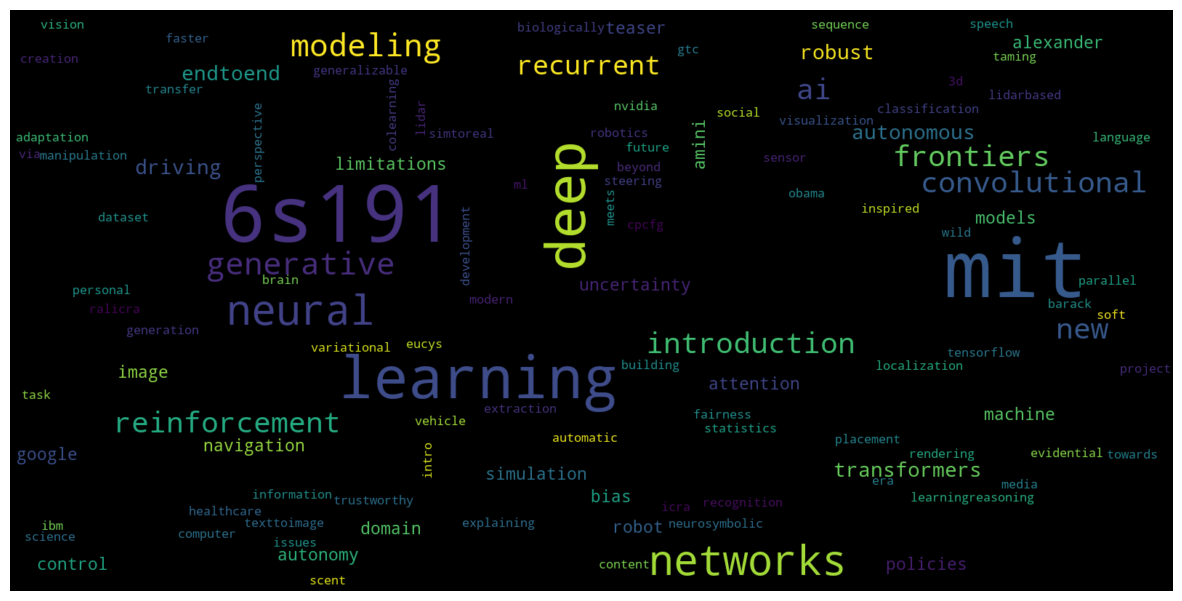

ValueError: could not convert string to float: 'Long-Videos'

In [163]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# WordCloud visualization
consolidated = ' '.join(word for word in data['Title'])
wordcloud = WordCloud(width=1600, height=800, max_font_size=110, collocations=False).generate(consolidated)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Countplot for Duration
sns.countplot(data['Duration'])
plt.show()
